In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
from src.pipeline import find_flux, find_noise_square, estimate_sigma
from src.analysis import gaussian_weight, wiener_deconvolution, calculate_gaap_flux
import warnings
import pandas as pd
from astropy.wcs import WCS
warnings.filterwarnings("ignore")

In [ ]:
# Set location of the data
location = '/net/vdesk/data2/deklerk/GAAP_data'

# Set the field
field = '53.0_-28.0'

In [4]:
with fits.open(f'/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/{field}/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits') as hdul:
    hdul.info()
    cat = Table(hdul[1].data)

ra_reference = cat['RIGHT_ASCENSION']
dec_reference = cat['DECLINATION']

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/53.0_-28.0/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EUC_MER__FINAL_CATALOG    1 BinTableHDU   1464   96164R x 470C   [K, D, D, D, D, K, K, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

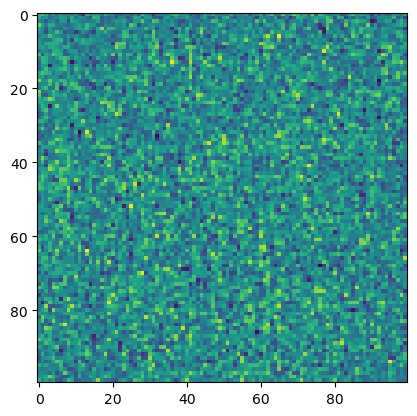

In [5]:
files = glob.glob(f'{location}/{field}/u_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file) as hdul:
    hdu = hdul[1]
    y0_rubin, x0_rubin, y1_rubin, x1_rubin = find_noise_square(hdul[1].data, 100)
    plt.imshow(hdul[1].data[y0_rubin:y1_rubin, x0_rubin:x1_rubin])
    plt.show()

In [6]:
files = glob.glob(f'{location}/{field}/u_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file) as hdul:
    hdu = hdul[1]
    image = hdu.data
    wcs = WCS(hdu.header)
    nx = hdu.header["NAXIS1"]
    ny = hdu.header["NAXIS2"]
x_c, y_c = wcs.wcs_world2pix(ra_reference, dec_reference, 0, ra_dec_order=True)
mask = (x_c >= 0) & (x_c < nx) & (y_c >= 0) & (y_c < ny)
x_c[~mask] = np.nan
y_c[~mask] = np.nan

In [7]:
psf_file = [f for f in files if f.endswith("psf.fits")][0]
with fits.open(psf_file) as hdul:
    psf = hdul[0].data

In [8]:
from scipy.optimize import curve_fit
def gaussian_2d(xy, amplitude, sigma, x0, y0):
    x, y = xy
    g = amplitude * np.exp(
        -(((x - x0)**2)/(2*sigma**2) + ((y - y0)**2)/(2*sigma**2))
    )
    return g.ravel()

In [9]:
original_sizes = np.linspace(2, 40, 20)
weight_sigmas = np.full(len(original_sizes), np.nan)
for i,original_size in enumerate(original_sizes):
    weight = gaussian_weight(ny//4, nx//4, ny // 8, nx // 8, original_size, original_size)
    weight_rescale = wiener_deconvolution(weight, psf, 0)
    y = np.arange(weight_rescale.shape[0])
    x = np.arange(weight_rescale.shape[1])
    x, y = np.meshgrid(x, y)

    # Flatten image and coordinates
    xdata = np.vstack((x.ravel(), y.ravel()))
    ydata = weight_rescale.ravel()

    amplitude_guess = np.max(weight_rescale)
    x0_guess = np.argmax(np.sum(weight_rescale, axis=0))
    y0_guess = np.argmax(np.sum(weight_rescale, axis=1))
    sigma_guess = weight_rescale.shape[1]/4

    initial_guess = [amplitude_guess, x0_guess, y0_guess, sigma_guess]

    try:
        popt, _ = curve_fit(gaussian_2d, xdata, ydata, p0=initial_guess)
        print(popt)
        amplitude, weight_sigma, x0, y0 = popt
        weight_sigmas[i] = weight_sigma
    except RuntimeError:
        weight_sigmas[i] = np.nan

[2.21075808e-02 2.80605534e+00 4.25001077e+02 4.24998537e+02]
[ 6.23050240e-03 -5.08882081e+00  4.25041900e+02  4.25090772e+02]
[ 3.00317788e-03 -7.29257590e+00  4.25050571e+02  4.25113154e+02]
[ 1.79287152e-03 -9.42784011e+00  4.25053525e+02  4.25122564e+02]
[ 1.19973184e-03 -1.15210607e+01  4.25054861e+02  4.25127436e+02]
[8.62186448e-04 1.35885724e+01 4.25055581e+02 4.25130290e+02]
[6.50795862e-04 1.56395534e+01 4.25056016e+02 4.25132108e+02]
[5.09251218e-04 1.76793575e+01 4.25056299e+02 4.25133338e+02]
[4.09656372e-04 1.97112757e+01 4.25056495e+02 4.25134210e+02]
[3.36839749e-04 2.17374309e+01 4.25056636e+02 4.25134851e+02]
[ 2.81947612e-04 -2.37592502e+01  4.25056741e+02  4.25135336e+02]
[ 2.39519467e-04 -2.57777269e+01  4.25056821e+02  4.25135713e+02]
[ 2.06033910e-04 -2.77935732e+01  4.25056885e+02  4.25136010e+02]
[ 1.79134829e-04 -2.98073127e+01  4.25056935e+02  4.25136249e+02]
[ 1.57196220e-04 -3.18193389e+01  4.25056976e+02  4.25136445e+02]
[ 1.39065910e-04 -3.38299532e+01  

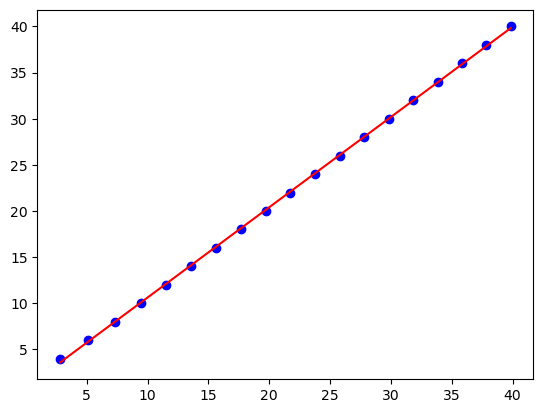

In [10]:
from numpy.polynomial import Polynomial

n = 1
coeffs = np.polyfit(np.abs(weight_sigmas[~np.isnan(weight_sigmas)]), original_sizes[~np.isnan(weight_sigmas)], n)
f = Polynomial(coeffs[::-1])  # reverse order

# Evaluate
x_new = np.linspace(np.nanmin(np.abs(weight_sigmas)), np.nanmax(np.abs(weight_sigmas)), 100)
y_fit = f(x_new)
plt.scatter(np.abs(weight_sigmas), original_sizes, color='blue')
plt.plot(x_new, y_fit, color='red')
plt.show()

In [11]:
print(np.nanmin(np.abs(weight_sigmas)), np.nanmax(np.abs(weight_sigmas)))

2.8060553422390213 39.855437262583735


In [12]:
y = np.arange(image.shape[0])
x = np.arange(image.shape[1])
x, y = np.meshgrid(x, y)

# Flatten image and coordinates
xdata = np.vstack((x.ravel(), y.ravel()))
ydata = image.ravel()

amplitude_guess = np.mean(image)
sigma_guess = 3

initial_guess = [amplitude_guess, sigma_guess]

In [13]:
ny, nx = image.shape
half_size = 30
aperture_sizes = np.full(len(x_c), np.nan)
for i, (x_center, y_center) in enumerate(zip(x_c, y_c)):
    if np.isnan(x_center) or np.isnan(y_center):
        continue

    x0 = int(round(x_center))
    y0 = int(round(y_center))

    # bounds (clip to image)
    x_min = max(0, x0 - half_size)
    x_max = min(nx, x0 + half_size + 1)
    y_min = max(0, y0 - half_size)
    y_max = min(ny, y0 + half_size + 1)

    cutout = image[y_min:y_max, x_min:x_max]

    # local coordinate grid
    y, x = np.mgrid[y_min:y_max, x_min:x_max]

    # fit only the cutout
    try:
        popt, _ = curve_fit(
            lambda xy, A, s: gaussian_2d(xy, A, s, x_center, y_center),
            (x, y),
            cutout.ravel(),
            p0=initial_guess
        )
        # print(f"Source {i}: Fitted sigma = {popt[1]:.2f} pixels")
        if np.abs(popt[1]) >= half_size:
            continue
            x_cut = x_center - x_min
            y_cut = y_center - y_min

            plt.imshow(cutout, origin='lower', cmap='viridis')
            plt.scatter(
                x_cut, y_cut,
                marker='+', s=100, c='red', linewidths=2, label='Fixed center'
            )
            plt.title(f"Source {i} – Large sigma: {popt[1]:.2f} pixels")
            plt.colorbar(label='Pixel Value')
            plt.legend()
            plt.show()
            break
        else:
            aperture_sizes[i] = np.abs(popt[1])
    except RuntimeError:
        continue
    # print(i)



In [14]:
np.nanmean(aperture_sizes)

np.float64(6.173629367987793)

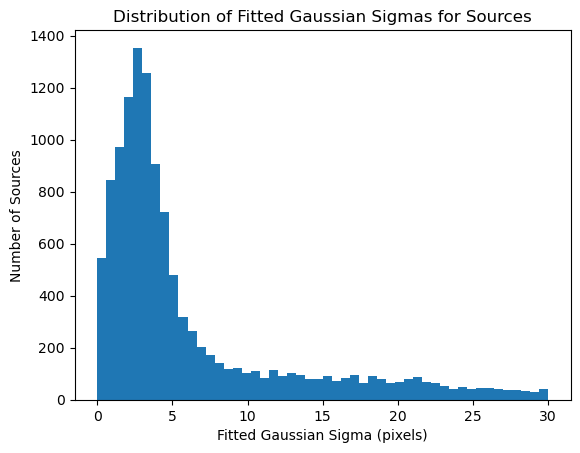

In [15]:
plt.hist(aperture_sizes[~np.isnan(aperture_sizes)], bins=50)
plt.xlabel('Fitted Gaussian Sigma (pixels)')
plt.ylabel('Number of Sources')
plt.title('Distribution of Fitted Gaussian Sigmas for Sources')
plt.show()

[ 4.05530815  4.16745395  4.28270104  4.40113518  4.52284451  4.6479196
  4.77645352  4.90854193  5.04428312  5.18377811  5.32713071  5.47444759
  5.62583838  5.78141574  5.94129545  6.10559649  6.27444112  6.447955
  6.62626723  6.80951053  6.99782126  7.19133954  7.39020939  7.59457881
  7.80459987  8.02042887  8.24222642  8.47015758  8.70439196  8.94510388
  9.19247246  9.4466818   9.70792105  9.97638464 10.25227234 10.53578947
 10.82714699 11.12656174 11.43425653 11.75046033 12.07540845 12.40934272
 12.75251163 13.10517056 13.46758194 13.84001548 14.22274832 14.61606529
 15.02025907 15.43563046 15.86248856 16.30115103 16.75194431 17.21520385
 17.69127441 18.18051026 18.68327548 19.1999442  19.73090092]


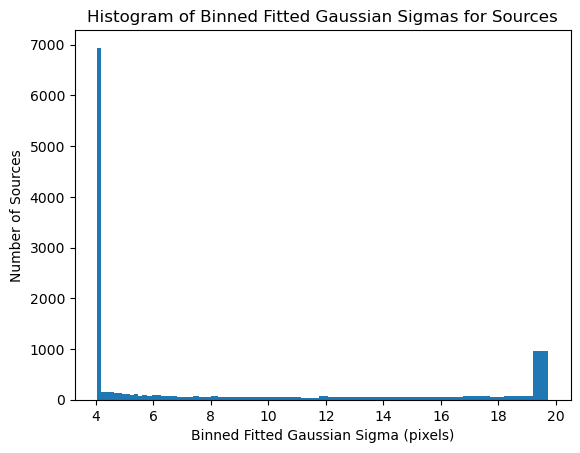

In [16]:
bins = np.logspace(np.log10(4), np.log10(20), 60)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# prepare array
sigma_binned = np.full_like(aperture_sizes, np.nan, dtype=float)

# mask valid (non-NaN) entries
mask = ~np.isnan(aperture_sizes)

# digitize only valid entries
bin_idx = np.digitize(aperture_sizes[mask], bins) - 1
bin_idx = np.clip(bin_idx, 0, len(bin_centers) - 1)

# assign binned values
sigma_binned[mask] = bin_centers[bin_idx]
print(np.unique(sigma_binned[~np.isnan(sigma_binned)]))
plt.hist(sigma_binned[~np.isnan(sigma_binned)], bins=bin_centers)
plt.xlabel('Binned Fitted Gaussian Sigma (pixels)')
plt.ylabel('Number of Sources')
plt.title('Histogram of Binned Fitted Gaussian Sigmas for Sources')
plt.show()

In [17]:
fluxes = {}

fluxes['ra'] = ra_reference
fluxes['dec'] = dec_reference

rubin_filters = ['g', 'r', 'i']
for filter in rubin_filters:
    fluxes[filter] = np.full_like(ra_reference, np.nan)
    fluxes[f'{filter}_sigma'] = np.full_like(ra_reference, np.nan)
for bin in np.unique(sigma_binned[~np.isnan(sigma_binned)])[:-1]:
    mask = sigma_binned == bin
    for filter in rubin_filters:
        files = glob.glob(f'{location}/{field}/{filter}_*.fits')
        image_file = [f for f in files if not f.endswith("psf.fits")][0]
        psf_file = [f for f in files if f.endswith("psf.fits")][0]

        flux_values, sigma = find_flux(
            image_file,
            "Rubin",
            f(bin),
            ra_reference[mask],
            dec_reference[mask],
            psf_path=psf_file,
            correlated=0,
            noise_x0=x0_rubin,
            noise_x1=x1_rubin,
            noise_y0=y0_rubin,
            noise_y1=y1_rubin
        )

        fluxes[filter][mask] = flux_values
        fluxes[f'{filter}_sigma'][mask] = sigma

Analyzing image
Analyzing image
Analyzing image
Deconvolving weight function
Analyzing image
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Analyzing image
Deconvolving weight function
Analyzing imag

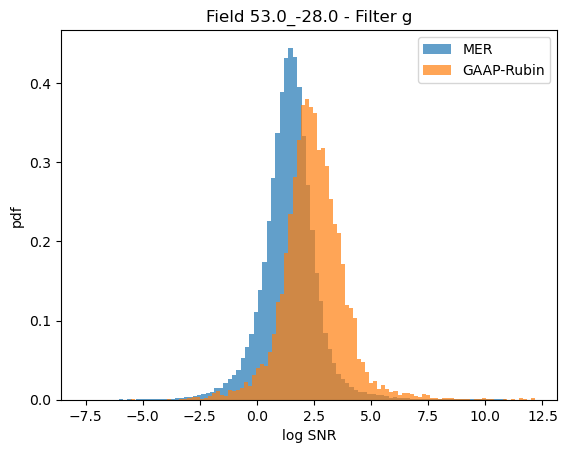

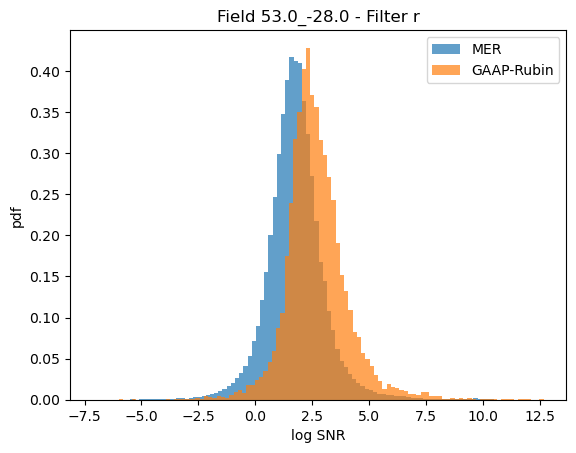

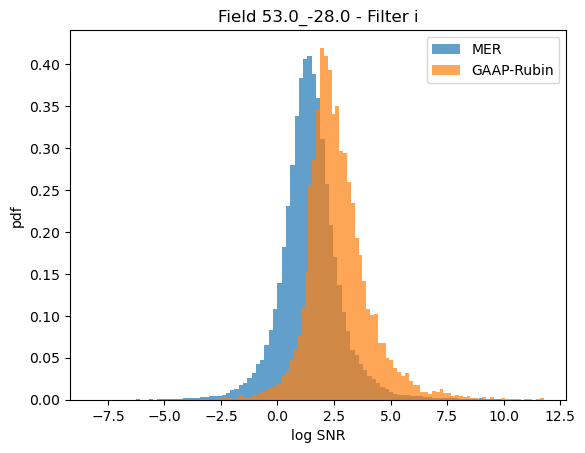

In [30]:
for filter in rubin_filters:
    plt.hist(np.log(cat[f'FLUX_{filter.upper()}_EXT_DECAM_4FWHM_APER'] / cat[f'FLUXERR_{filter.upper()}_EXT_DECAM_4FWHM_APER']), bins=100, density=True, alpha=0.7, label='MER')
    plt.hist(np.log(fluxes[filter][fluxes[filter]>0]/fluxes[f'{filter}_sigma'][fluxes[filter]>0]), bins=100, density=True, alpha=0.7, label='GAAP-Rubin')
    # plt.hist(np.log(fluxes['DES-G'][fluxes['DES-G']>0]/fluxes['DES-G_sigma'][fluxes['DES-G']>0]), bins=100, density=True, alpha=0.7, label='GAAP-Euclid')
    plt.title(f'Field {field} - Filter {filter}')
    plt.xlabel('log SNR')
    plt.ylabel('pdf')
    plt.legend()
    plt.show()

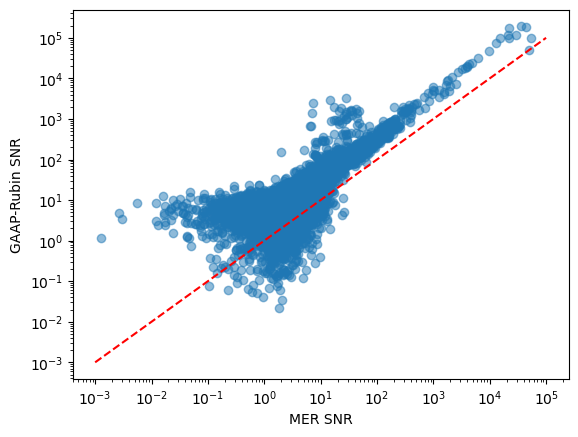

Percent of sources where GAAP-Rubin SNR > MER SNR: 0.9323832923832924
Average SNR improvement factor (GAAP-Rubin / MER): 6.034395716852703


In [32]:
snr_meer = cat['FLUX_G_EXT_DECAM_4FWHM_APER'] / cat['FLUXERR_G_EXT_DECAM_4FWHM_APER']
snr_gaap = fluxes['g']/fluxes['g_sigma']
cutoff_snr = 1e-3
mask = (snr_meer > cutoff_snr) & (snr_gaap > cutoff_snr) & (np.isfinite(snr_gaap)) & (np.isfinite(snr_meer))
plt.scatter(snr_meer[mask],
            snr_gaap[mask],
            alpha=0.5)
plt.plot([1e-3, 1e5], [1e-3, 1e5], 'r--')
plt.xlabel('MER SNR')
plt.ylabel('GAAP-Rubin SNR')
plt.loglog()
plt.show()
print("Percent of sources where GAAP-Rubin SNR > MER SNR:", np.nansum(snr_gaap[mask] > snr_meer[mask])/ np.sum(~np.isnan(snr_gaap[mask])))
print("Average SNR improvement factor (GAAP-Rubin / MER):", np.nanmean(snr_gaap[mask] / snr_meer[mask]))

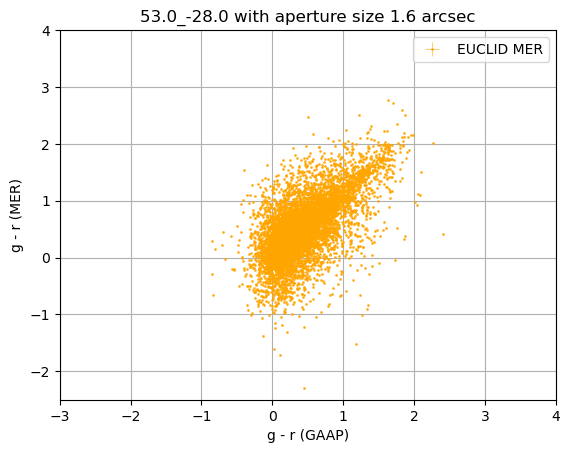

In [29]:
filter_1 = 'g'   # e.g., master_table column name
filter_2 = 'r'
filter_3 = 'r'
filter_4 = 'i'

plot_error = False

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    # y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
        (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
    )
    # yerr = 2.5 / np.log(10) * np.sqrt(
    #     (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    #     (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
    # )

    # Optional: filter points with very large errors
    # mask = (xerr**2 + yerr**2 < 1)
    # new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    # gaap_error = xerr**2 + yerr**2
    # # plt.show()
    # # Plot
    # plt.errorbar(
    #     x_color[mask], y_color[mask],
    #     xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    #     fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
    # )
    # plt.title(f'{field} with aperture size {8/5} arcsec')
    # plt.xlabel(f'{filter_1} - {filter_2}')
    # plt.ylabel(f'{filter_3} - {filter_4}')
    # plt.xlim(-1, 4)
    # plt.ylim(-2.5, 2.5)
    # plt.show()
    y_color = -2.5 * np.log10(cat['FLUX_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])
    # y_color = -2.5 * np.log10(cat['FLUX_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])

    # Compute errors from sigma dictionary
    yerr = 2.5 / np.log(10) * np.sqrt(
        (cat['FLUXERR_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_G_EXT_DECAM_2FWHM_APER'])**2 +
        (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2
    )
    # yerr = 2.5 / np.log(10) * np.sqrt(
    #     (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2 +
    #     (cat['FLUXERR_I_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])**2
    # )

    mask = (xerr**2 + yerr**2 < 1)
    # new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    # euclid_error = xerr**2 + yerr**2
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='orange', ms=1, elinewidth=0.5, alpha=0.8, label='EUCLID MER'
    )

    plt.title(f'{field} with aperture size {8/5} arcsec')
    plt.xlabel(f'g - r (GAAP)')
    plt.ylabel(f'g - r (MER)')
    plt.xlim(-3, 4)
    plt.ylim(-2.5, 4)
    plt.legend()
    plt.show()

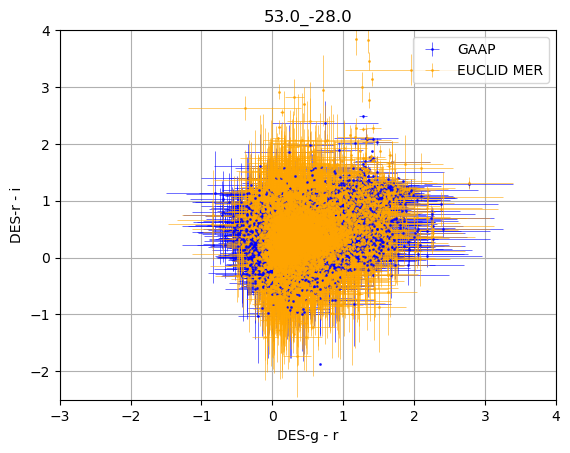

In [28]:
filter_1 = 'g'   # e.g., master_table column name
filter_2 = 'r'
filter_3 = 'r'
filter_4 = 'i'

plot_error = True

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
        (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
        (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
    )

    # Optional: filter points with very large errors
    mask = (xerr**2 + yerr**2 < 1)
    new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    gaap_error = xerr**2 + yerr**2
    # plt.show()
    # Plot
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
    )
    # plt.title(f'{field}')
    # plt.xlabel(f'{filter_1} - {filter_2}')
    # plt.ylabel(f'{filter_3} - {filter_4}')
    # plt.xlim(-1, 4)
    # plt.ylim(-2.5, 2.5)
    # plt.show()
    y_color = -2.5 * np.log10(cat['FLUX_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])
    y_color = -2.5 * np.log10(cat['FLUX_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])

    # Compute errors from sigma dictionary
    yerr = 2.5 / np.log(10) * np.sqrt(
        (cat['FLUXERR_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_G_EXT_DECAM_2FWHM_APER'])**2 +
        (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2 +
        (cat['FLUXERR_I_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])**2
    )

    mask = (xerr**2 + yerr**2 < 1)
    new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    euclid_error = xerr**2 + yerr**2
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='orange', ms=1, elinewidth=0.5, alpha=0.8, label='EUCLID MER'
    )

    plt.title(f'{field}')
    plt.xlabel(f'DES-{filter_1} - {filter_2}')
    plt.ylabel(f'DES-{filter_3} - {filter_4}')
    plt.xlim(-3, 4)
    plt.ylim(-2.5, 4)
    plt.legend()
    plt.show()